In [232]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
import math
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import MisrToolkit as Mtk
import sys
import glob
import h5py
import time
import calendar
import scipy
from scipy import spatial
from regrid_cats_cth import regrid_cats

#Nearest-neighbour search routine
def do_kdtree(A, pt):
    mytree = scipy.spatial.cKDTree(A,balanced_tree=False,compact_nodes=False)
    dist, indexes = mytree.query(pt,distance_upper_bound=np.inf)
    return indexes

#Calculate physical distance between two geographical coordinates
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

CTH_CATS = np.zeros((360,720))
CTH_MISR = np.zeros((360,720))
CTH_MODIS = np.zeros((360,720))
CTH_diff = np.zeros((360,720))
count = np.zeros((360,720))
#count[:,:] = 1
myfile = open('CATS_coincidence_backscatter_statitics_Aug_2017', 'w')
myfile2 = open('CATS_height_MISR_no_retreival_statistics_Aug_2017','w')
myfile3 = open('CATS_collocated_coordinate_points_Aug_2017', 'w')

#open files in loop for reading
FILE_NAME=sorted(glob.glob('./CATS/Aug_2017/*.hdf5'))
MISR_DIRECTORY='/data/keeling/a/arkam2/b/MISR/Aug_2017/'
for i in range(14,15):
    try:
        hdf = h5py.File(FILE_NAME[i], 'r')
        print("Operating on CATS orbit:", FILE_NAME[i])
        y = FILE_NAME[i]
    except:
        continue
#print out the groups of variables
#print("Keys: %s" % hdf.keys())
#Keys: [u'geolocation', u'layer_descriptor', u'metadata_parameters', u'optical_properties']
#0-geolocation
#1-layer_descriptor
#2-metadata_parameters
#3-optical_properties

#print out the variables within geolocation
#for key in geolocation.keys():
#...     print(key)
#0-CATS_Fore_FOV_Angle
#1-CATS_Fore_FOV_Latitude
#2-CATS_Fore_FOV_Longitude
#3-Index_Top_Bin_Fore_FOV
#4-Solar_Azimuth_Angle
#5-Solar_Zenith_Angle

#Get latitude and longitude
    geolocation = hdf['geolocation']
    lat = geolocation['CATS_Fore_FOV_Latitude']
    latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
    lon = geolocation['CATS_Fore_FOV_Longitude']
    longitude = lon[:,2]
    metadata_parameters = hdf['metadata_parameters']
    altitude = metadata_parameters['Bin_Altitude_Array'][()]
#print(np.shape(longitude))

    optical_properties = hdf['profile']
    name = 'Feature_Type_Fore_FOV'
    feature_type = optical_properties[name]
    backscatter = optical_properties['Particulate_Backscatter_Coefficient_1064_Fore_FOV']
    print(np.shape(feature_type))
    UTC_time = optical_properties['Profile_UTC_Time']
#print out the variables within geolocation
#for key in optical_properties.keys():
#        print(key)

#Aerosol_Optical_Depth_1064_Fore_FOV
#Aerosol_Optical_Depth_Uncertainty_1064_Fore_FOV
#Aerosol_Type_Fore_FOV
#Cloud_Optical_Depth_1064_Fore_FOV
#Cloud_Optical_Depth_Uncertainty_1064_Fore_FOV
#Cloud_Phase_Fore_FOV
#Cloud_Phase_Score_Fore_FOV
#Column_Optical_Depth_1064_Fore_FOV
#Column_Optical_Depth_Uncertainty_1064_Fore_FOV
#DEM_Surface_Altitude_Fore_FOV
#Day_Night_Flag
#Extinction_Coefficient_1064_Fore_FOV
#Extinction_Coefficient_Uncertainty_1064_Fore_FOV
#Extinction_QC_Flag_1064_Fore_FOV
#Feature_Type_Fore_FOV
#Feature_Type_Score_Fore_FOV
#Horizontal_Resolution_Detection_Fore_FOV
#Ice_Water_Content_1064_Fore_FOV
#Ice_Water_Content_1064_Uncertainty_Fore_FOV
#Lidar_Surface_Altitude_Fore_FOV
#Multiple_Scattering_Factor_1064_Fore_FOV
#Particulate_Backscatter_Coefficient_1064_Fore_FOV
#Particulate_Backscatter_Coefficient_Uncertainty_1064_Fore_FOV
#Percent_Opacity_Fore_FOV
#Profile_ID
#Profile_UTC_Date
#Profile_UTC_Time
#Sky_Condition_Fore_FOV
#Surface_Type_Fore_FOV
#Total_Depolarization_Ratio_1064_Fore_FOV
#Total_Depolarization_Ratio_Uncertainty_1064_Fore_FOV

#Now time to isolate the date time information from CATS filename to figure out
#MISR and MODIS paths that coincide with the CATS orbit
    orbit_date=(y[50:60])
    start_time=(y[60:69]).replace('-',':')
    end_time=(y[69:78]).replace('-',':')
    start_time=orbit_date+start_time
    end_time=orbit_date+end_time
    #print(start_time,end_time)
    
#Find out the MISR list of orbits that fall within the time range of CATS orbit
    try:
        MISR_orbits = Mtk.time_range_to_orbit_list(start_time,end_time)
        print(MISR_orbits)
    except:
        continue
    
    for j in range(0,len(MISR_orbits)):
        MISR_path=Mtk.orbit_to_path(MISR_orbits[j])
        print(MISR_path)
        if MISR_path<10:
            path=str(0)+str(0)+str(MISR_path)
        elif (MISR_path<100) & (MISR_path>9):
            path=str(0)+str(MISR_path)
        else:
            path=str(MISR_path)
        MISR_file = MISR_DIRECTORY+'MISR_AM1_TC_CLOUD_P'+path+'_O0'+str(MISR_orbits[j])+'_F01_0001.hdf'
        print(MISR_file)
        try:
            m = Mtk.MtkFile(MISR_file)
        except:
            continue
        block_num_time = np.array(m.block_metadata_field_read('PerBlockMetadataTime', 'BlockCenterTime'))
        block_num_list = np.array(m.block_metadata_field_read('PerBlockMetadataCommon', 'Block_number'))
        block_num_list = block_num_list[np.logical_and(block_num_time[:]!='',block_num_time[:]!='0000-00-00T00:00:00.000000Z')]
        block_num_time = block_num_time[np.logical_and(block_num_time[:]!='',block_num_time[:]!='0000-00-00T00:00:00.000000Z')]
        hr = np.zeros(len(block_num_list))
        mins = np.zeros(len(block_num_list))
        #print(block_num_time)
        for k in range(0,len(block_num_time)):
            #print(block_num_time[k][14:16])
            hr[k]=int(block_num_time[k][11:13])
            mins[k]=int(block_num_time[k][14:16])
        
        for k in range(0, len(latitude)): #upto len(latitude)
            CATS_time = UTC_time[k,1]
            CATS_lat = latitude[k]
            CATS_long = longitude[k]
            CATS_coord = [CATS_lat,CATS_long]
            CATS_profile = feature_type[:,k]
            CATS_backscatter = backscatter[:,k]
            #print(np.shape(CATS_coord))
            #print(CATS_lat,CATS_long)
            Hours = (CATS_time*24)%24
            Minutes = (Hours%1)*60
            Seconds = (Minutes%1)*60
            #print("CATS : %d:%02d:%02d" % (Hours, Minutes, Seconds))
            Minutes = int(Minutes)
            Hours = int(Hours)
            if (Minutes==1):
                start_time_window_min=59
                start_time_window_hr=Hours-1
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            elif (Minutes==2):
                start_time_window_min=0
                start_time_window_hr=Hours
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            elif (Minutes==59):
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=1
                end_time_window_hr=Hours+1
            elif (Minutes==58):
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=0
                end_time_window_hr=Hours+1
            else:
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            #print(start_time_window_hr,start_time_window_min)  
            #print(end_time_window_hr,end_time_window_min)
            try:
                start_block = np.min(block_num_list[np.logical_and(hr==start_time_window_hr,mins==start_time_window_min)])
                end_block = np.max(block_num_list[np.logical_and(hr==end_time_window_hr,mins==end_time_window_min)])
            except:
                continue
            #print(start_block,end_block)
            num_blocks = end_block-start_block
            geog_dist = np.zeros(num_blocks)
            #print(num_blocks)
            for l in range(start_block,end_block):
                r = Mtk.MtkRegion(MISR_path, l,l)
                center_coord = r.center
                #print((center_coord))
                geog_dist[l-start_block] = haversine(CATS_coord,center_coord)/1000.0

            if (np.min(geog_dist)<=380.0):
                r = Mtk.MtkRegion(MISR_path, start_block, end_block)
                map_info = r.snap_to_grid(MISR_path, 1100)
                latlon = np.asarray(map_info.create_latlon())
                lat = latlon[0,:,:]
                lon = latlon[1,:,:]
                ydata=np.shape(lat)[1]
                xdata=np.shape(lon)[0]
                ncoll=xdata*ydata
                #print(xdata,ydata)
                misr_points = ([lat.ravel(), lon.ravel()])
                d = m.grid('Stereo_1.1_km').field('CloudTopHeight').read(r)
                misr_collocated = (d.data()*0.001).ravel()
                #print(np.shape(misr_points))
                CM_collocation = do_kdtree(np.transpose(misr_points),CATS_coord)
                #MISR_point = int(CM_collocation)
                nn_MISR_lat = misr_points[0][CM_collocation]
                nn_MISR_long = misr_points[1][CM_collocation]
                print(CATS_lat,CATS_long)
                print(nn_MISR_lat,nn_MISR_long)
                if (abs(nn_MISR_lat-CATS_lat)<=0.1) and (abs(nn_MISR_long-CATS_long)<=0.1) and \
                   (nn_MISR_lat != -200.0) and (nn_MISR_long != -200.0):
                        print(start_block,end_block)
                        try:
                            CATS_height = altitude[np.min(np.where(CATS_profile==1))]
                            ht = np.min(np.where(CATS_profile==1))
                            CATS_scatter = CATS_backscatter[np.min(np.where(CATS_profile==1))]
                            MISR_height = misr_collocated[CM_collocation]
                        except:
                            continue
                        print(CATS_height,MISR_height)
                        if (MISR_height!=-9.999):
                            r=int((180+CATS_long)/0.5)+1
                            s=int((90+CATS_lat)/0.5)+1
                            CTH_diff[s,r] = CTH_diff[s,r] + (CATS_height - MISR_height)
                            CTH_CATS[s,r] = CTH_CATS[s,r] + CATS_height
                            CTH_MISR[s,r] = CTH_MISR[s,r] + MISR_height
                            count[s,r] = count[s,r]+1
                            myfile.write(str(CATS_scatter)+" "+str(CTH_diff[s,r]/count[s,r])+"\n")
                            myfile3.write(str(CATS_lat)+" "+str(CATS_long)+" "+str(k)+" "+str(CTH_MISR[s,r]/count[s,r])+"\n")
                        if (MISR_height==-9.999):
                            myfile2.write(str(CATS_scatter)+" "+str(CATS_height)+"\n")
np.savetxt('CTH_diff_Aug_2017',np.divide(CTH_diff, count, out=np.zeros_like(CTH_diff), where=count!=0))
np.savetxt('CTH_MISR_Aug_2017',np.divide(CTH_MISR, count, out=np.zeros_like(CTH_MISR), where=count!=0))
np.savetxt('CTH_CATS_Aug_2017',np.divide(CTH_CATS, count, out=np.zeros_like(CTH_CATS), where=count!=0))
            
myfile.close()
myfile2.close()
myfile3.close()

('Operating on CATS orbit:', './CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5')
(533, 4127)
[93736, 93737]
132
/data/keeling/a/arkam2/b/MISR/Aug_2017/MISR_AM1_TC_CLOUD_P132_O093736_F01_0001.hdf
(-50.97072, 73.64676)
(-51.76819789140178, 74.47897510806813)
(-50.9622, 73.714005)
(-51.76819789140178, 74.47897510806813)
(-50.953648, 73.78123)
(-51.76819789140178, 74.47897510806813)
(-50.945045, 73.84843)
(-51.76819789140178, 74.47897510806813)
(-50.936394, 73.9156)
(-51.76819789140178, 74.47897510806813)
(-50.92771, 73.98275)
(-51.76819789140178, 74.47897510806813)
(-50.918987, 74.049866)
(-51.76819789140178, 74.47897510806813)
(-50.910217, 74.11697)
(-51.24214138881961, 74.95401844311098)
(-50.901413, 74.18404)
(-51.21339052525078, 74.96545887321763)
(-50.89257, 74.25108)
(-51.184638298361186, 74.97688403486498)
(-50.883667, 74.3181)
(-51.14629987983759, 74.99209388903712)
(-50.874725, 74.385086)
(-51.11754448246864, 75.00348355070193)
(-50.86575, 74

In [69]:
Time = 0.17674070601851852
Hours = (Time*24)%24
Minutes = (Hours%1)*60
Seconds = (Minutes%1)*60

print("%d:%02d:%02d" % (Hours, Minutes, Seconds))

4:14:30


In [11]:
im = [1.3,2.0,4.5]
ir = [6.11,9.3, 4.56e-4]
myfile = open('xyz.txt', 'w')
for line in range(0,len(im)):
    myfile.write(str(im[line])+" "+str(ir[line])+"\n")

myfile.close()

In [ ]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
import math
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import MisrToolkit as Mtk
import sys
import glob
import h5py
import time
import calendar
import scipy
from scipy import spatial
from regrid_cats_cth import regrid_cats

#Nearest-neighbour search routine
def do_kdtree(A, pt):
    mytree = scipy.spatial.cKDTree(A,balanced_tree=False,compact_nodes=False)
    dist, indexes = mytree.query(pt,distance_upper_bound=np.inf)
    return indexes

#Calculate physical distance between two geographical coordinates
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

CTH_CATS = np.zeros((360,720))
CTH_MISR = np.zeros((360,720))
CTH_MODIS = np.zeros((360,720))
CTH_diff = np.zeros((360,720))
count = np.zeros((360,720))
#count[:,:] = 1
myfile = open('CATS_coincidence_characteristic_files_Aug_2017_1', 'w')


#open files in loop for reading
FILE_NAME=sorted(glob.glob('./CATS/Aug_2017/*.hdf5'))
MISR_DIRECTORY='/data/keeling/a/arkam2/b/MISR/Aug_2017/'
for i in range(10,15):
    try:
        hdf = h5py.File(FILE_NAME[i], 'r')
        print("Operating on CATS orbit:", FILE_NAME[i])
        y = FILE_NAME[i]
    except:
        continue
#print out the groups of variables
#print("Keys: %s" % hdf.keys())
#Keys: [u'geolocation', u'layer_descriptor', u'metadata_parameters', u'optical_properties']
#0-geolocation
#1-layer_descriptor
#2-metadata_parameters
#3-optical_properties

#print out the variables within geolocation
#for key in geolocation.keys():
#...     print(key)
#0-CATS_Fore_FOV_Angle
#1-CATS_Fore_FOV_Latitude
#2-CATS_Fore_FOV_Longitude
#3-Index_Top_Bin_Fore_FOV
#4-Solar_Azimuth_Angle
#5-Solar_Zenith_Angle

#Get latitude and longitude
    geolocation = hdf['geolocation']
    lat = geolocation['CATS_Fore_FOV_Latitude']
    latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
    lon = geolocation['CATS_Fore_FOV_Longitude']
    longitude = lon[:,2]
    metadata_parameters = hdf['metadata_parameters']
    altitude = metadata_parameters['Bin_Altitude_Array'][()]
#print(np.shape(longitude))

    optical_properties = hdf['profile']
    name = 'Feature_Type_Fore_FOV'
    feature_type = optical_properties[name]
    backscatter = optical_properties['Particulate_Backscatter_Coefficient_1064_Fore_FOV']
    print(np.shape(feature_type))
    UTC_time = optical_properties['Profile_UTC_Time']
#print out the variables within geolocation
#for key in optical_properties.keys():
#        print(key)

#Aerosol_Optical_Depth_1064_Fore_FOV
#Aerosol_Optical_Depth_Uncertainty_1064_Fore_FOV
#Aerosol_Type_Fore_FOV
#Cloud_Optical_Depth_1064_Fore_FOV
#Cloud_Optical_Depth_Uncertainty_1064_Fore_FOV
#Cloud_Phase_Fore_FOV
#Cloud_Phase_Score_Fore_FOV
#Column_Optical_Depth_1064_Fore_FOV
#Column_Optical_Depth_Uncertainty_1064_Fore_FOV
#DEM_Surface_Altitude_Fore_FOV
#Day_Night_Flag
#Extinction_Coefficient_1064_Fore_FOV
#Extinction_Coefficient_Uncertainty_1064_Fore_FOV
#Extinction_QC_Flag_1064_Fore_FOV
#Feature_Type_Fore_FOV
#Feature_Type_Score_Fore_FOV
#Horizontal_Resolution_Detection_Fore_FOV
#Ice_Water_Content_1064_Fore_FOV
#Ice_Water_Content_1064_Uncertainty_Fore_FOV
#Lidar_Surface_Altitude_Fore_FOV
#Multiple_Scattering_Factor_1064_Fore_FOV
#Particulate_Backscatter_Coefficient_1064_Fore_FOV
#Particulate_Backscatter_Coefficient_Uncertainty_1064_Fore_FOV
#Percent_Opacity_Fore_FOV
#Profile_ID
#Profile_UTC_Date
#Profile_UTC_Time
#Sky_Condition_Fore_FOV
#Surface_Type_Fore_FOV
#Total_Depolarization_Ratio_1064_Fore_FOV
#Total_Depolarization_Ratio_Uncertainty_1064_Fore_FOV

#Now time to isolate the date time information from CATS filename to figure out
#MISR and MODIS paths that coincide with the CATS orbit
    orbit_date=(y[50:60])
    start_time=(y[60:69]).replace('-',':')
    end_time=(y[69:78]).replace('-',':')
    start_time=orbit_date+start_time
    end_time=orbit_date+end_time
    #print(start_time,end_time)
    
#Find out the MISR list of orbits that fall within the time range of CATS orbit
    try:
        MISR_orbits = Mtk.time_range_to_orbit_list(start_time,end_time)
        print(MISR_orbits)
    except:
        continue
    
    for j in range(0,len(MISR_orbits)):
        MISR_path=Mtk.orbit_to_path(MISR_orbits[j])
        print(MISR_path)
        if MISR_path<10:
            path=str(0)+str(0)+str(MISR_path)
        elif (MISR_path<100) & (MISR_path>9):
            path=str(0)+str(MISR_path)
        else:
            path=str(MISR_path)
        MISR_file = MISR_DIRECTORY+'MISR_AM1_TC_CLOUD_P'+path+'_O0'+str(MISR_orbits[j])+'_F01_0001.hdf'
        print(MISR_file)
        try:
            m = Mtk.MtkFile(MISR_file)
        except:
            continue
        block_num_time = np.array(m.block_metadata_field_read('PerBlockMetadataTime', 'BlockCenterTime'))
        block_num_list = np.array(m.block_metadata_field_read('PerBlockMetadataCommon', 'Block_number'))
        block_num_list = block_num_list[np.logical_and(block_num_time[:]!='',block_num_time[:]!='0000-00-00T00:00:00.000000Z')]
        block_num_time = block_num_time[np.logical_and(block_num_time[:]!='',block_num_time[:]!='0000-00-00T00:00:00.000000Z')]
        hr = np.zeros(len(block_num_list))
        mins = np.zeros(len(block_num_list))
        #print(block_num_time)
        for k in range(0,len(block_num_time)):
            #print(block_num_time[k][14:16])
            hr[k]=int(block_num_time[k][11:13])
            mins[k]=int(block_num_time[k][14:16])
        
        for k in range(0, len(latitude)): #upto len(latitude)
            CATS_time = UTC_time[k,1]
            CATS_lat = latitude[k]
            CATS_long = longitude[k]
            CATS_coord = [CATS_lat,CATS_long]
            CATS_profile = feature_type[:,k]
            CATS_backscatter = backscatter[:,k]
            #print(np.shape(CATS_coord))
            print(CATS_lat,CATS_long)
            Hours = (CATS_time*24)%24
            Minutes = (Hours%1)*60
            Seconds = (Minutes%1)*60
            #print("CATS : %d:%02d:%02d" % (Hours, Minutes, Seconds))
            Minutes = int(Minutes)
            Hours = int(Hours)
            if (Minutes==1):
                start_time_window_min=59
                start_time_window_hr=Hours-1
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            elif (Minutes==2):
                start_time_window_min=0
                start_time_window_hr=Hours
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            elif (Minutes==59):
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=1
                end_time_window_hr=Hours+1
            elif (Minutes==58):
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=0
                end_time_window_hr=Hours+1
            else:
                start_time_window_min=Minutes-2
                start_time_window_hr=Hours
                end_time_window_min=Minutes+2
                end_time_window_hr=Hours
            #print(start_time_window_hr,start_time_window_min)  
            #print(end_time_window_hr,end_time_window_min)
            try:
                start_block = np.min(block_num_list[np.logical_and(hr==start_time_window_hr,mins==start_time_window_min)])
                end_block = np.max(block_num_list[np.logical_and(hr==end_time_window_hr,mins==end_time_window_min)])
            except:
                continue
            #print(start_block,end_block)
            num_blocks = end_block-start_block
            geog_dist = np.zeros(num_blocks)
            #print(num_blocks)
            for l in range(start_block,end_block):
                r = Mtk.MtkRegion(MISR_path, l,l)
                center_coord = r.center
                #print((center_coord))
                geog_dist[l-start_block] = haversine(CATS_coord,center_coord)/1000.0

            if (np.min(geog_dist)<=380.0):
                r = Mtk.MtkRegion(MISR_path, start_block, end_block)
                map_info = r.snap_to_grid(MISR_path, 1100)
                latlon = np.asarray(map_info.create_latlon())
                lat = latlon[0,:,:]
                lon = latlon[1,:,:]
                ydata=np.shape(lat)[1]
                xdata=np.shape(lon)[0]
                ncoll=xdata*ydata
                print(xdata,ydata)
                misr_points = ([lat.ravel(), lon.ravel()])
                d = m.grid('Stereo_1.1_km').field('CloudTopHeight').read(r)
                misr_collocated = (d.data()*0.001).ravel()
                print(np.shape(misr_points))
                CM_collocation = do_kdtree(np.transpose(misr_points),CATS_coord)
                #MISR_point = int(CM_collocation)
                nn_MISR_lat = misr_points[0][CM_collocation]
                nn_MISR_long = misr_points[1][CM_collocation]
                print(nn_MISR_lat,nn_MISR_long)
                if (abs(nn_MISR_lat-CATS_lat)<=0.1) and (abs(nn_MISR_long-CATS_long)<=0.1) and \
                   (nn_MISR_lat != -200.0) and (nn_MISR_long != -200.0):
                        try:
                            CATS_height = altitude[np.min(np.where(CATS_profile==1))]
                            CATS_scatter = CATS_backscatter[np.min(np.where(CATS_profile==1))]
                            MISR_height = misr_collocated[CM_collocation]
                        except:
                            continue
                        print(CATS_height,MISR_height)
                        if (MISR_height!=-9.999):
                            if ((CATS_height - MISR_height)<2.0):
                                myfile.write("CATS CTH - MISR CTH < 2 km:"+"\n")
                                myfile.write("MISR TC_CLOUD file: "+MISR_file+"\n")
                                myfile.write("CATS Pro file: "+y+"\n")
                            if ((CATS_height - MISR_height)>2.0 and (CATS_height - MISR_height)<10.0):
                                myfile.write("CATS CTH - MISR CTH < 10 km:"+"\n")
                                myfile.write("MISR TC_CLOUD file: "+MISR_file+"\n")
                                myfile.write("CATS Pro file: "+y+"\n")
                            if ((CATS_height - MISR_height)>10.0):
                                myfile.write("CATS CTH - MISR CTH > 10 km:"+"\n")
                                myfile.write("MISR TC_CLOUD file: "+MISR_file+"\n")
                                myfile.write("CATS Pro file: "+y+"\n")
                            if ((CATS_height - MISR_height)<0.0):
                                myfile.write("CATS CTH - MISR CTH < 0 km:"+"\n")
                                myfile.write("MISR TC_CLOUD file: "+MISR_file+"\n")
                                myfile.write("CATS Pro file: "+y+"\n")                              
                                
myfile.close()

**MISR Orbit 93736**

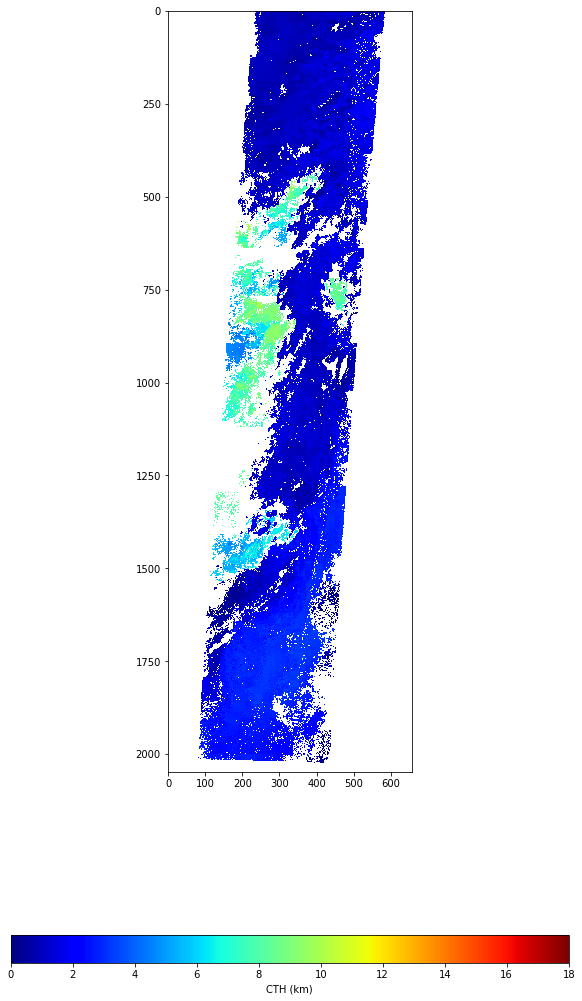

(2048, 656)


In [2]:
import MisrToolkit as Mtk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
file = '/data/keeling/a/arkam2/b/MISR/Aug_2017/MISR_AM1_TC_CLOUD_P132_O093736_F01_0001.hdf'
m = Mtk.MtkFile(file)
path_number = m.attr_get('Path_number')
block_num_time = np.array(m.block_metadata_field_read('PerBlockMetadataTime', 'BlockCenterTime'))
block_num_list = np.array(m.block_metadata_field_read('PerBlockMetadataCommon', 'Block_number'))
block_num_list = block_num_list[np.logical_and(block_num_time[:]!='',block_num_time[:]!='0000-00-00T00:00:00.000000Z')]
start_block = block_num_list[0]
end_block = block_num_list[len(block_num_list)-1]
r = Mtk.MtkRegion(path_number, 128, 143)
d = m.grid('Stereo_1.1_km').field('CloudTopHeight').read(r)
d = d.data()*0.001
plt.figure(figsize=(10,20))
my_cmap = matplotlib.cm.get_cmap('jet')
my_cmap.set_under('w')
plt.imshow((d),interpolation='none', cmap=my_cmap, vmin=.001)
cb = plt.colorbar(orientation='horizontal')
cb.set_label(r'CTH (km)')
plt.clim(0,18)
plt.show()
print(np.shape(d))

In [ ]:
/data/keeling/a/arkam2/b/MISR/Aug_2017/MISR_AM1_TC_CLOUD_P132_O093736_F01_0001.hdf
./CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5

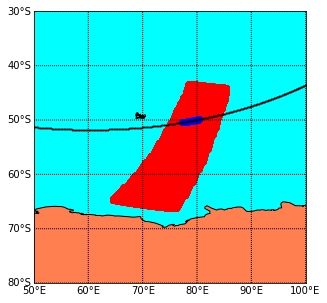

In [167]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import MisrToolkit as Mtk
import numpy as np
file = '/data/keeling/a/arkam2/b/MISR/Aug_2017/MISR_AM1_TC_CLOUD_P132_O093736_F01_0001.hdf'
coord_file = 'CATS_collocated_coordinate_points_Aug_2017'
FILE_NAME='./CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5'
hdf = h5py.File(FILE_NAME, 'r')
geolocation = hdf['geolocation']
lat = geolocation['CATS_Fore_FOV_Latitude']
latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
lon = geolocation['CATS_Fore_FOV_Longitude']
longitude = lon[:,2]
A = np.loadtxt(coord_file)
m = Mtk.MtkFile(file)
path_number = m.attr_get('Path_number')
map_info = Mtk.MtkRegion(path_number, 126, 143).snap_to_grid(path_number, 1100)
latlon = np.asarray(map_info.create_latlon())
lat = latlon[0,:,:]
lon = latlon[1,:,:]
lat[np.where(lat[:,:]==-200.0)]=np.nan
lat[np.where(lat[:,:]==-200.0)]=np.nan
plt.figure(figsize=(5,5))
m = Basemap(projection='cyl', resolution='l', 
            llcrnrlat=-80, urcrnrlat = -30,
           llcrnrlon=50, urcrnrlon = 100,lat_ts=65)
m.drawcoastlines(linewidth=1.0)
m.drawparallels(np.arange(-90., 91., 10.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180, 181., 10.), labels=[0, 0, 0, 1])
m.scatter(lon, lat, latlon=True, color = 'r')
m.drawlsmask(land_color='coral',ocean_color='aqua',lakes=True)
m.scatter(A[:,1], A[:,0], latlon=True, color = 'blue')
m.scatter(longitude,latitude, latlon=True, color='k',s=0.2)
plt.show()

**CATS Backscatter Profile for Co-location with MISR Orbit 93736**

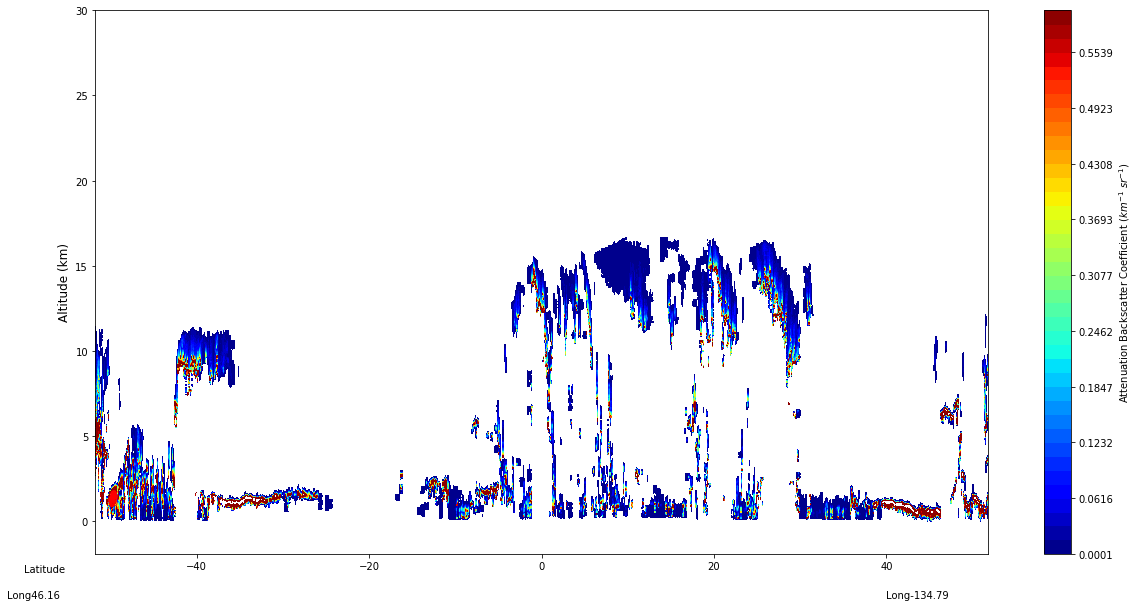

In [93]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys
import h5py
import time
import calendar
from matplotlib import colors,ticker
import matplotlib

#open file for reading
FILE_NAME='./CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5'
hdf = h5py.File(FILE_NAME, 'r')
coord_file = 'CATS_coincidence_backscatter_statitics_Aug_2017'
geolocation = hdf['geolocation']

#Get latitude and longitude
lat = geolocation['CATS_Fore_FOV_Latitude']
latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
lon = geolocation['CATS_Fore_FOV_Longitude']
longitude = lon[:,2]
metadata_parameters = hdf['metadata_parameters']
altitude = metadata_parameters['Bin_Altitude_Array'][()]

#print(np.shape(longitude))
optical_properties = hdf['profile']
A=np.loadtxt(coord_file)

y_scale = 23
name = 'Particulate_Backscatter_Coefficient_1064_Fore_FOV'
data_raw = optical_properties[name]
data_raw=data_raw[:,:].astype('float')
data_raw[data_raw<-900]=np.nan

#feature_type[np.where(feature_type==-999.9)]=np.nan

coordinates = np.zeros((np.shape(A)[0],2))
for i in range(0,np.shape(A)[0]):
    ht = np.where(np.abs(altitude[:]-A[i,3])==np.min(np.abs(altitude[:]-A[i,3])))
    coordinates[i,1] = int(A[i,2])
    coordinates[i,0] = int(ht[0])
        
# Regrid original data based on altitude.
plt.figure(figsize=(20,10))
xx,yy = np.meshgrid(latitude,altitude)
#color = ['lightcyan', 'blue', 'grey', 'white']
#label = [0,1,2,3]
#colorbar_ticks = ['N/A','1','2','3']

plt.ylabel("Altitude (km)", fontsize=12)
#plt.xlabel("N/A = not applicable, 1 = cloud, 2 = undetermined , 3 = aerosol", fontsize=12)
my_cmap = plt.cm.jet
my_cmap.set_over('k', 0.6)

v = np.linspace(1e-4, 0.6, 40, endpoint=True)
#plt.contour(xx, yy, data_raw, v, cmap=my_cmap)
plt.contourf(xx,yy,data_raw ,v, cmap=my_cmap)
#plt.contourf(xx,yy,coordinates ,v, cmap=my_cmap)
#my_cmap.set_bad('white',np.nan)
#my_cmap.set_bad('white',0)
#loc = np.arange(0,max(label)+1,(max(label)+1)/float(len(color)))
plt.text(-60,-3, 'Latitude')
plt.text(-62,-4.5,'Long'+str(round(longitude[0],2)))
plt.text(40,-4.5,'Long'+str(round(longitude[len(longitude)-1],2)))
for i in range(0,np.shape(coordinates)[0]):
    plt.text(xx[int(coordinates[i,1]),int(coordinates[i,1])],yy[int(coordinates[i,0]),int(coordinates[i,1])],'o',color='red')

cb = plt.colorbar()
plt.clim(0,0.6)
cb.set_label(r'Attenuation Backscatter Coefficient ($km^{-1}$ $sr^{-1}$)')
#cb.set_ticks(loc)
#cb.set_ticklabels(colorbar_ticks)
plt.show()

In [112]:
data_raw = optical_properties[name]
data_raw=data_raw[:,:].astype('float')
data_raw[data_raw<-900]=np.nan
np.nanmean(data_raw)

0.006802019563257987

In [214]:
print(np.shape(coordinates)[0])
print(np.shape(data_raw)[1])

46
4127


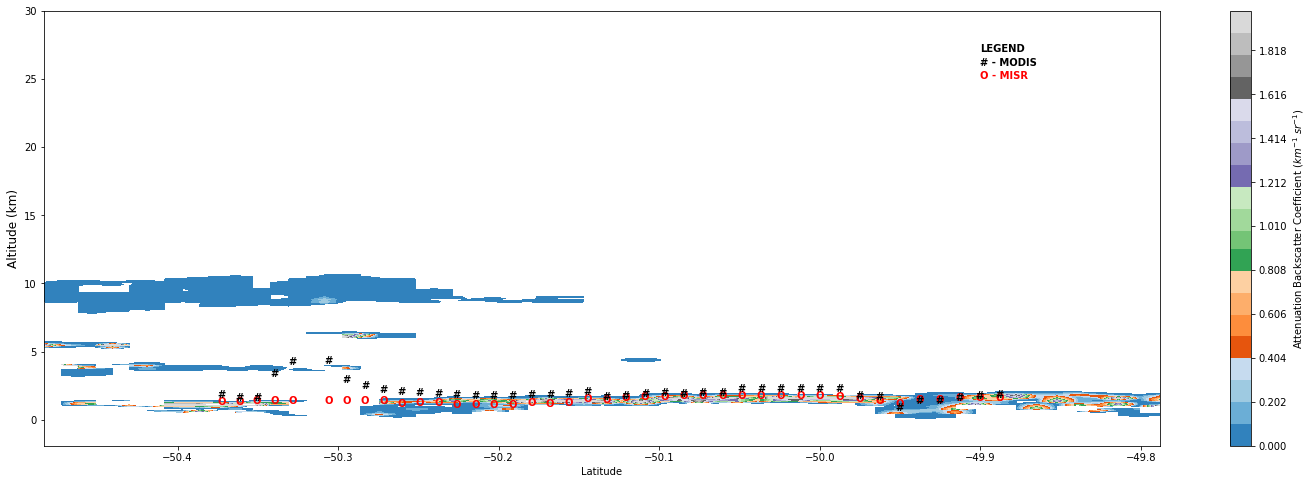

In [91]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys
import h5py
import time
import calendar
from matplotlib import colors,ticker
import matplotlib

#open file for reading
FILE_NAME='./CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5'
hdf = h5py.File(FILE_NAME, 'r')
coord_file = 'CATS_coincidence_backscatter_statitics_Aug_2017'
geolocation = hdf['geolocation']

#Get latitude and longitude
lat = geolocation['CATS_Fore_FOV_Latitude']
latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
lon = geolocation['CATS_Fore_FOV_Longitude']
longitude = lon[:,2]
metadata_parameters = hdf['metadata_parameters']
altitude = metadata_parameters['Bin_Altitude_Array'][()]
base_altitude = altitude[0]
#print(np.shape(longitude))
optical_properties = hdf['profile']
A=np.loadtxt(coord_file)

y_scale = 23
name = 'Particulate_Backscatter_Coefficient_1064_Fore_FOV'
data_raw = optical_properties[name]
data_raw=data_raw[:,:].astype('float')
data_raw[data_raw<-900]=np.nan
data_raw=data_raw[:,450:510]
latitude=latitude[450:510]
longitude=longitude[450:510]
#feature_type[np.where(feature_type==-999.9)]=np.nan

coordinates = np.zeros((np.shape(A)[0],3))
for i in range(0,np.shape(A)[0]):
    ht = np.where(np.abs(altitude[:]-A[i,3])==np.min(np.abs(altitude[:]-A[i,3])))
    mod_ht = np.where(np.abs(altitude[:]-A[i,4])==np.min(np.abs(altitude[:]-A[i,4])))
    coordinates[i,1] = int(A[i,2])
    coordinates[i,0] = int(ht[0])
    coordinates[i,2] = int(mod_ht[0])
        
# Regrid original data based on altitude.
plt.figure(figsize=(25,8))
xx,yy = np.meshgrid(latitude,altitude)
#color = ['lightcyan', 'blue', 'grey', 'white']
#label = [0,1,2,3]
#colorbar_ticks = ['N/A','1','2','3']

plt.ylabel("Altitude (km)", fontsize=12)
#plt.xlabel("N/A = not applicable, 1 = cloud, 2 = undetermined , 3 = aerosol", fontsize=12)
my_cmap = plt.cm.tab20c
#my_cmap.set_over('k', 1.0)

v = np.linspace(0,2.0,100, endpoint=True)
#plt.contour(xx, yy, data_raw, v, cmap=my_cmap)
plt.contourf(xx,yy,data_raw ,v, cmap=my_cmap)
#plt.contourf(xx,yy,coordinates ,v, cmap=my_cmap)
#my_cmap.set_bad('white',np.nan)
#my_cmap.set_bad('white',0)
#loc = np.arange(0,max(label)+1,(max(label)+1)/float(len(color)))
#loc = np.arange(0,max(label)+1,(max(label)+1)/float(len(color)))
#plt.text(-60,-3, 'Latitude')
#plt.text(-62,-4.5,'Long'+str(round(longitude[0],2)))
#plt.text(40,-4.5,'Long'+str(round(longitude[len(longitude)-1],2)))
for i in range(0,np.shape(coordinates)[0]):
    plt.text(xx[int(coordinates[i,0]),int(coordinates[i,1])-450],yy[int(coordinates[i,0]),int(coordinates[i,1])-450],'O', color='red', weight='bold')
    plt.text(xx[int(coordinates[i,2]),int(coordinates[i,1])-450],yy[int(coordinates[i,2]),int(coordinates[i,1])-450],'#', color='black',weight='bold')
cb = plt.colorbar()
cb.set_label(r'Attenuation Backscatter Coefficient ($km^{-1}$ $sr^{-1}$)')
#plt.clim(0,2.0)
plt.text(-49.9,27,'LEGEND', color='black',weight='bold')
plt.text(-49.9,25,'O - MISR', color = 'red',weight='bold')
plt.text(-49.9,26,'# - MODIS', color = 'black',weight='bold')
plt.xlabel('Latitude')
#cb.set_ticks(loc)
#cb.set_ticklabels(colorbar_ticks)
plt.show()

In [52]:
np.shape(A)

(41, 5)

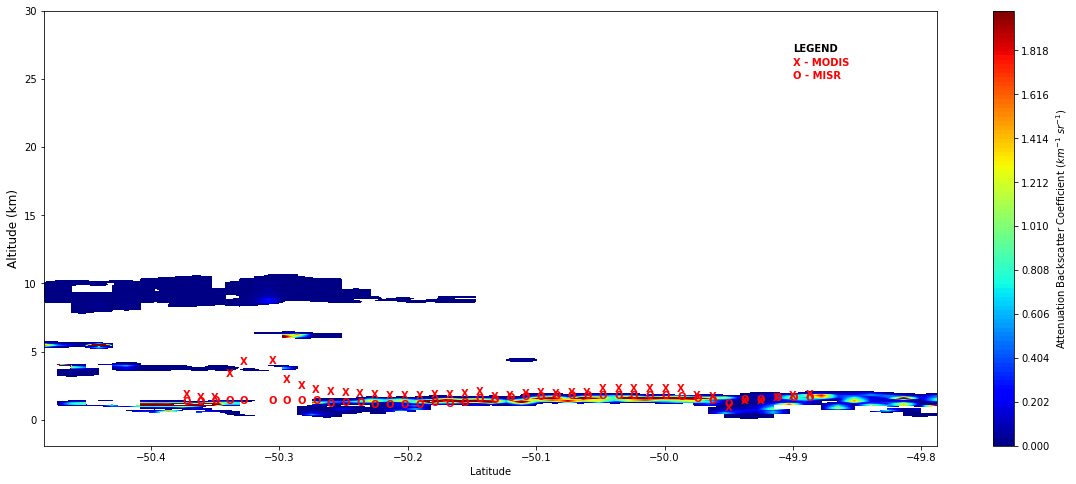

In [89]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys
import h5py
import time
import calendar
from matplotlib import colors,ticker
import matplotlib

#open file for reading
FILE_NAME='./CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5'
hdf = h5py.File(FILE_NAME, 'r')
coord_file = 'CATS_coincidence_backscatter_statitics_Aug_2017'
geolocation = hdf['geolocation']

#Get latitude and longitude
lat = geolocation['CATS_Fore_FOV_Latitude']
latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
lon = geolocation['CATS_Fore_FOV_Longitude']
longitude = lon[:,2]
metadata_parameters = hdf['metadata_parameters']
altitude = metadata_parameters['Bin_Altitude_Array'][()]
base_altitude = altitude[0]
#print(np.shape(longitude))
optical_properties = hdf['profile']
A=np.loadtxt(coord_file)

y_scale = 23
name = 'Particulate_Backscatter_Coefficient_1064_Fore_FOV'
data_raw = optical_properties[name]
data_raw=data_raw[:,:].astype('float')
data_raw[data_raw<-900]=np.nan
data_raw=data_raw[:,450:510]
latitude=latitude[450:510]
longitude=longitude[450:510]
#feature_type[np.where(feature_type==-999.9)]=np.nan

coordinates = np.zeros((np.shape(A)[0],3))
for i in range(0,np.shape(A)[0]):
    ht = np.where(np.abs(altitude[:]-A[i,3])==np.min(np.abs(altitude[:]-A[i,3])))
    mod_ht = np.where(np.abs(altitude[:]-A[i,4])==np.min(np.abs(altitude[:]-A[i,4])))
    coordinates[i,1] = int(A[i,2])
    coordinates[i,0] = int(ht[0])
    coordinates[i,2] = int(mod_ht[0])
        
# Regrid original data based on altitude.
plt.figure(figsize=(20,8))
xx,yy = np.meshgrid(latitude,altitude)
#color = ['lightcyan', 'blue', 'grey', 'white']
#label = [0,1,2,3]
#colorbar_ticks = ['N/A','1','2','3']

plt.ylabel("Altitude (km)", fontsize=12)
#plt.xlabel("N/A = not applicable, 1 = cloud, 2 = undetermined , 3 = aerosol", fontsize=12)
#my_cmap = plt.cm.geosoft
#my_cmap.set_over('k', 1.0)

v = np.linspace(0, 2.0, 100, endpoint=True)
#plt.contour(xx, yy, data_raw, v, cmap=my_cmap)
plt.contourf(xx,yy,data_raw ,v, cmap='jet')

for i in range(0,np.shape(coordinates)[0]):
    plt.text(xx[int(coordinates[i,0]),int(coordinates[i,1])-450],yy[int(coordinates[i,0]),int(coordinates[i,1])-450],'O', color='red', weight='bold')
    plt.text(xx[int(coordinates[i,2]),int(coordinates[i,1])-450],yy[int(coordinates[i,2]),int(coordinates[i,1])-450],'X', color='red',weight='bold')
cb = plt.colorbar()
cb.set_label(r'Attenuation Backscatter Coefficient ($km^{-1}$ $sr^{-1}$)')
#plt.clim(0,2.0)
plt.text(-49.9,27,'LEGEND', color='black',weight='bold')
plt.text(-49.9,25,'O - MISR', color = 'red',weight='bold')
plt.text(-49.9,26,'X - MODIS', color = 'red',weight='bold')
plt.xlabel('Latitude')
#cb.set_ticks(loc)
#cb.set_ticklabels(colorbar_ticks)
plt.show()

**MISR + CATS co-location for August 2017 - Statistics vis-a-vis top-of-layer CATS cloud phase** 

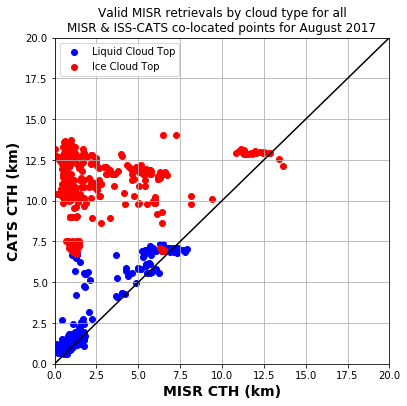

In [17]:
import numpy as np
import matplotlib.pyplot as plt

A = np.loadtxt('CATS_coincidence_backscatter_statitics_Aug_2017')
ice_cl = A[np.where(A[:,3]==3)]
CATS_ice_cth = ice_cl[:,1]
MISR_ice_cth = ice_cl[:,2]
liq_cl = A[np.where(A[:,3]==1)]
CATS_liq_cth = liq_cl[:,1]
MISR_liq_cth = liq_cl[:,2]
x=np.linspace(0,20,20)
plt.figure(figsize=(6,6))
plt.scatter(MISR_liq_cth,CATS_liq_cth,color='b',label='Liquid Cloud Top')
plt.scatter(MISR_ice_cth,CATS_ice_cth,color='r',label='Ice Cloud Top')
plt.plot(x,x,'k')
plt.legend()
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('MISR CTH (km)',size=14,weight='bold')
plt.ylabel('CATS CTH (km)',size=14,weight='bold')
plt.title('Valid MISR retrievals by cloud type for all'+'\n'+'MISR & ISS-CATS co-located points for August 2017')
plt.grid()
plt.show()

**Important !!!! Re-run the code while outputting the phase of the no-retrieval points**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

A = np.loadtxt('CATS_height_MISR_no_retreival_statistics_Aug_2017')
ice_cl = A[np.where(A[:,3]==3)]
CATS_ice_cth = ice_cl[:,1]
MISR_ice_cth = ice_cl[:,2]
liq_cl = A[np.where(A[:,3]==1)]
CATS_liq_cth = liq_cl[:,1]
MISR_liq_cth = liq_cl[:,2]
x=np.linspace(0,20,20)
plt.figure(figsize=(6,6))
plt.scatter(MISR_liq_cth,CATS_liq_cth,color='b',label='Liquid Cloud Top')
plt.scatter(MISR_ice_cth,CATS_ice_cth,color='r',label='Ice Cloud Top')
plt.plot(x,x,'k')
plt.legend()
plt.xlim(0,20)
plt.ylim(0,20)
plt.xlabel('MISR CTH (km)',size=14,weight='bold')
plt.ylabel('CATS CTH (km)',size=14,weight='bold')
plt.title('Valid MISR retrievals by cloud type for all'+'\n'+'MISR & ISS-CATS co-located points for August 2017')
plt.grid()
plt.show()

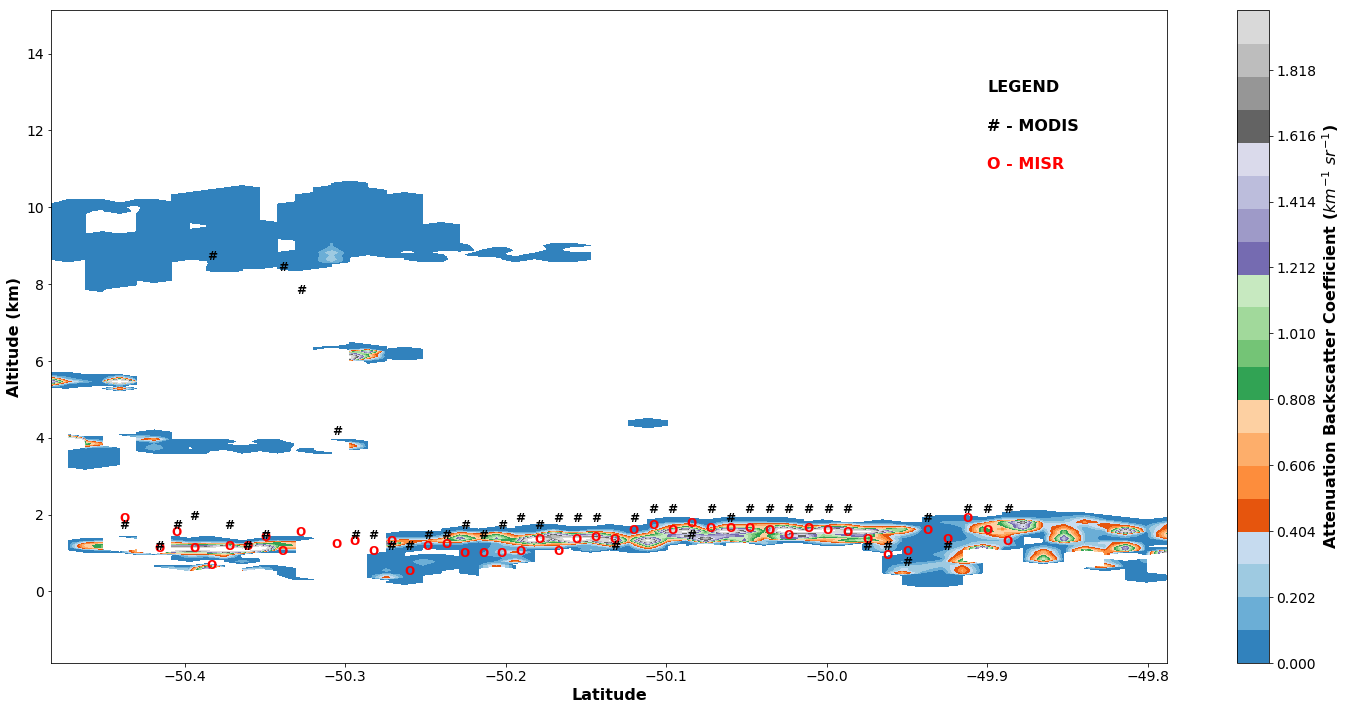

In [24]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys
import h5py
import time
import calendar
from matplotlib import colors,ticker
import matplotlib

#open file for reading
FILE_NAME='./CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5'
hdf = h5py.File(FILE_NAME, 'r')
coord_file = 'CATS_MODIS_coincidence_backscatter_statitics_Aug_2017_1'
geolocation = hdf['geolocation']

#Get latitude and longitude
lat = geolocation['CATS_Fore_FOV_Latitude']
latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
lon = geolocation['CATS_Fore_FOV_Longitude']
longitude = lon[:,2]
metadata_parameters = hdf['metadata_parameters']
altitude = metadata_parameters['Bin_Altitude_Array'][()]
altitude = altitude[248:532] 
base_altitude = altitude[0]
#print(np.shape(longitude))
optical_properties = hdf['profile']
A=np.loadtxt(coord_file)

y_scale = 23
name = 'Particulate_Backscatter_Coefficient_1064_Fore_FOV'
data_raw = optical_properties[name]
data_raw=data_raw[:,:].astype('float')
data_raw[data_raw<-900]=np.nan
data_raw=data_raw[248:532,450:510]
latitude=latitude[450:510]
longitude=longitude[450:510]
#feature_type[np.where(feature_type==-999.9)]=np.nan

coordinates = np.zeros((np.shape(A)[0],3))
for i in range(0,np.shape(A)[0]):
    ht = np.where(np.abs(altitude[:]-A[i,3])==np.min(np.abs(altitude[:]-A[i,3])))
    mod_ht = np.where(np.abs(altitude[:]-A[i,4])==np.min(np.abs(altitude[:]-A[i,4])))
    coordinates[i,1] = int(A[i,2])
    coordinates[i,0] = int(ht[0])
    coordinates[i,2] = int(mod_ht[0])
     
# Regrid original data based on altitude.
plt.figure(figsize=(25,12))
xx,yy = np.meshgrid(latitude,altitude)
#color = ['lightcyan', 'blue', 'grey', 'white']
#label = [0,1,2,3]
#colorbar_ticks = ['N/A','1','2','3']

plt.ylabel("Altitude (km)", fontsize=16, weight='bold')
#plt.xlabel("N/A = not applicable, 1 = cloud, 2 = undetermined , 3 = aerosol", fontsize=12)
my_cmap = plt.cm.tab20c
#my_cmap.set_over('k', 1.0)

v = np.linspace(0,2.0,100, endpoint=True)
#plt.contour(xx, yy, data_raw, v, cmap=my_cmap)
plt.contourf(xx,yy,data_raw ,v, cmap=my_cmap)
#plt.contourf(xx,yy,coordinates ,v, cmap=my_cmap)
#my_cmap.set_bad('white',np.nan)
#my_cmap.set_bad('white',0)
#loc = np.arange(0,max(label)+1,(max(label)+1)/float(len(color)))
#loc = np.arange(0,max(label)+1,(max(label)+1)/float(len(color)))
#plt.text(-60,-3, 'Latitude')
#plt.text(-62,-4.5,'Long'+str(round(longitude[0],2)))
#plt.text(40,-4.5,'Long'+str(round(longitude[len(longitude)-1],2)))
for i in range(0,np.shape(coordinates)[0]):
    plt.text(xx[int(coordinates[i,0]),int(coordinates[i,1])-450],yy[int(coordinates[i,0]),int(coordinates[i,1])-450],'O', fontsize=12, color='red', weight='bold')
    plt.text(xx[int(coordinates[i,2]),int(coordinates[i,1])-450],yy[int(coordinates[i,2]),int(coordinates[i,1])-450],'#', fontsize=12, color='black',weight='bold')
cb = plt.colorbar()
cb.set_label(r'Attenuation Backscatter Coefficient ($km^{-1}$ $sr^{-1}$)',fontsize=16, color='black',weight='bold')
cb.ax.tick_params(labelsize=14)
#plt.clim(0,2.0)
plt.text(-49.9,13,'LEGEND', fontsize=16, color='black',weight='bold')
plt.text(-49.9,11,'O - MISR', fontsize=16, color = 'red',weight='bold')
plt.text(-49.9,12,'# - MODIS', fontsize=16, color = 'black',weight='bold')
plt.xlabel('Latitude',fontsize=16,weight='bold')
plt.tick_params(labelsize=14)
#cb.set_ticks(loc)
#cb.set_ticklabels(colorbar_ticks)
plt.show()

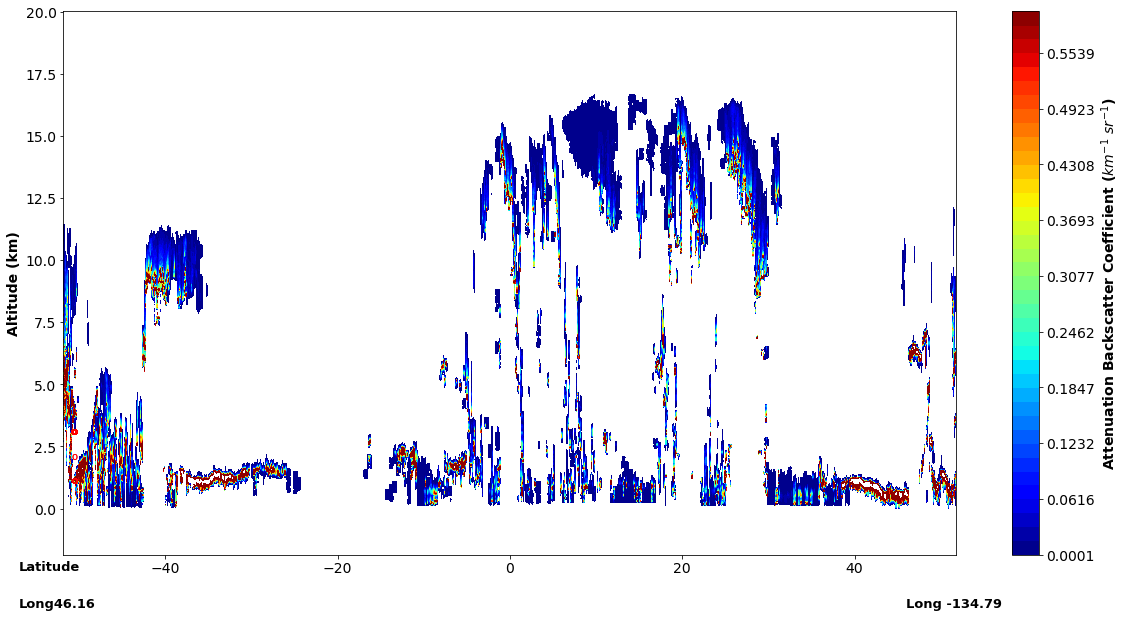

In [34]:
#!/usr/bin/python

#import necessary modules
from pyhdf import SD
import numpy as np
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.pyplot as plt
import sys
import h5py
import time
import calendar
from matplotlib import colors,ticker
import matplotlib

#open file for reading
FILE_NAME='./CATS/Aug_2017/CATS-ISS_L2O_D-M7.2-V2-01_05kmPro.2017-08-02T04-28-30T05-16-39UTC.hdf5'
hdf = h5py.File(FILE_NAME, 'r')
coord_file = 'CATS_coincidence_backscatter_statitics_Aug_2017'
geolocation = hdf['geolocation']

#Get latitude and longitude
lat = geolocation['CATS_Fore_FOV_Latitude']
latitude = lat[:,2] #have a shape of (3838,3) of combined 3 orbits
lon = geolocation['CATS_Fore_FOV_Longitude']
longitude = lon[:,2]
metadata_parameters = hdf['metadata_parameters']
altitude = metadata_parameters['Bin_Altitude_Array'][()]
altitude = altitude[166:532]
#print(np.shape(longitude))
optical_properties = hdf['profile']
A=np.loadtxt(coord_file)

y_scale = 23
name = 'Particulate_Backscatter_Coefficient_1064_Fore_FOV'
data_raw = optical_properties[name]
data_raw=data_raw[166:532,:].astype('float')
data_raw[data_raw<-900]=np.nan

#feature_type[np.where(feature_type==-999.9)]=np.nan

coordinates = np.zeros((np.shape(A)[0],2))
for i in range(0,np.shape(A)[0]):
    ht = np.where(np.abs(altitude[:]-A[i,3])==np.min(np.abs(altitude[:]-A[i,3])))
    coordinates[i,1] = int(A[i,2])
    coordinates[i,0] = int(ht[0])
        
# Regrid original data based on altitude.
plt.figure(figsize=(20,10))
xx,yy = np.meshgrid(latitude,altitude)
#color = ['lightcyan', 'blue', 'grey', 'white']
#label = [0,1,2,3]
#colorbar_ticks = ['N/A','1','2','3']

plt.ylabel("Altitude (km)", fontsize=14,weight='bold')
#plt.xlabel("N/A = not applicable, 1 = cloud, 2 = undetermined , 3 = aerosol", fontsize=12)
my_cmap = plt.cm.jet
my_cmap.set_over('k', 0.6)

v = np.linspace(1e-4, 0.6, 40, endpoint=True)
#plt.contour(xx, yy, data_raw, v, cmap=my_cmap)
plt.contourf(xx,yy,data_raw ,v, cmap=my_cmap)
#plt.contourf(xx,yy,coordinates ,v, cmap=my_cmap)
#my_cmap.set_bad('white',np.nan)
#my_cmap.set_bad('white',0)
#loc = np.arange(0,max(label)+1,(max(label)+1)/float(len(color)))
plt.text(-57,-2.5, 'Latitude',fontsize=13,weight='bold')
plt.text(-57,-4.0,'Long'+str(round(longitude[0],2)),fontsize=13,weight='bold')
plt.text(46,-4.0,'Long '+str(round(longitude[len(longitude)-1],2)),fontsize=13,weight='bold')
for i in range(0,np.shape(coordinates)[0]):
    plt.text(xx[int(coordinates[i,1]),int(coordinates[i,1])],yy[int(coordinates[i,0]),int(coordinates[i,1])],'o',color='red')

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.clim(0,0.6)
cb.set_label(r'Attenuation Backscatter Coefficient ($km^{-1}$ $sr^{-1}$)', fontsize=14,weight='bold')
plt.tick_params(labelsize=14)
#cb.set_ticks(loc)
#cb.set_ticklabels(colorbar_ticks)
plt.show()